# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from trackReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

# Load Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [4]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
file_input_name = '../build/event_total.root'
# file_input_name = '../build/event.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

histogram_wall = [title.split('_')[1] for title in histogram_titles]
print(histogram_wall)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [5]:
tree = file_input_uproot['photoSensor_hits;1']

position_relative_x = tree['photoSensor_hits_position_relative_x'].array()
position_relative_y = tree['photoSensor_hits_position_relative_y'].array()

histogram = file_input_pyroot.Get(histogram_names[0])
n_bins_x = histogram.GetNbinsX()
n_bins_y = histogram.GetNbinsY()
values = np.zeros((n_bins_x, n_bins_y))
x_edges = []
y_edges = []
for i in range(1, n_bins_x + 2):
    x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
for i in range(1, n_bins_y + 2):
    y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))
x_edges[ 0] -= 1e-9
y_edges[ 0] -= 1e-9
x_edges[-1] += 1e-9
y_edges[-1] += 1e-9

position_relative_x_bins = pd.Series(pd.cut(np.array(position_relative_x), bins=x_edges, retbins=False))
position_relative_y_bins = pd.Series(pd.cut(np.array(position_relative_y), bins=y_edges, retbins=False))
position_relative_x_binned = position_relative_x_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_y_binned = position_relative_y_bins.apply(lambda x: (x.right + x.left) / 2)
position_relative_x_nBin = position_relative_x_bins.cat.codes
position_relative_y_nBin = position_relative_y_bins.cat.codes

position_initial_x = tree['photoSensor_hits_position_initial_x'].array()
position_initial_y = tree['photoSensor_hits_position_initial_y'].array()
position_initial_z = tree['photoSensor_hits_position_initial_z'].array()

time = tree['photoSensor_hits_time'].array()
photoSensorID = tree['photoSensor_hits_photoSensorID'].array()
photoSensorPosition = [(float(ID.split('_')[2]), float(ID.split('_')[3]), float(ID.split('_')[4])) for ID in photoSensorID]
photoSensorWall = [ID.split('_')[1] for ID in photoSensorID]
photoSensorDirection = []
for wall in photoSensorWall:
    if wall == '+x':
        photoSensorDirection.append([-1, 0, 0])
    elif wall == '-x':
        photoSensorDirection.append([+1, 0, 0])
    elif wall == '+y':
        photoSensorDirection.append([0, -1, 0])
    elif wall == '-y':
        photoSensorDirection.append([0, +1, 0])
    elif wall == '+z':
        photoSensorDirection.append([0, 0, -1])
    elif wall == '-z':
        photoSensorDirection.append([0, 0, +1])

df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'] = photoSensorID
df_hits['sensor_direction'] = photoSensorDirection
df_hits['sensor_position'] = photoSensorPosition
df_hits['relativePosition'] = list(zip(position_relative_x, position_relative_y))
df_hits['relativePosition_binned'] = list(zip(position_relative_x_binned, position_relative_y_binned))
df_hits['relativePosition_nBin'] = list(zip(position_relative_x_nBin, position_relative_y_nBin))
df_hits['initialPosition'] = list(zip(position_initial_x, position_initial_y, position_initial_z))
df_hits['time'] = time

# print(df_hits)

In [6]:
primary_tree = file_input_uproot['primary;1']
position_x = primary_tree['primary_position_x'].array()
position_y = primary_tree['primary_position_y'].array()
position_z = primary_tree['primary_position_z'].array()
time = primary_tree['primary_time'].array()

df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = list(zip(position_x, position_y, position_z))
df_primary['time'] = time

# Constants
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [7]:
CM_PER_RAD = 34.14230382
MM_PER_CM = 10
CM_PER_M = 100
Y_LIM = 10 * MM_PER_CM
C_M = 299792458
C_CM = C_M * CM_PER_M
N_XENON = 1.84
C_XENON_M_PER_S = C_M / N_XENON
C_XENON_CM_PER_S = C_XENON_M_PER_S * CM_PER_M
C_XENON_MM_PER_S = C_XENON_CM_PER_S * MM_PER_CM
NS_PER_S = 1e9
C_XENON_MM_PER_NS = C_XENON_MM_PER_S / NS_PER_S

# Get Filter Density Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)

In [9]:
search_radii = range(0, 10)
search_numbers = range(0, 10)

df_hits_original = df_hits.copy()

for search_radius in search_radii:
    for search_number in search_numbers:
        df_hits = filter_hits(df_hits_original, search_radius, search_number)
        df_hits = make_r(df_hits)
        df_hits = filter_r(df_hits, Y_LIM)
        df_hits = make_theta(df_hits, rToTheta)
        df_hits = make_phi(df_hits)

        df_hits = make_reconstructedVector_direction(df_hits)
        df_hits = make_reconstructedPoint_primary_distance(df_hits, df_primary)
        df_hits = make_reconstructedPoint_initial_distance(df_hits)

        PDF, hist, bins = get_PDF(df_hits['reconstructedPoint_primary_distance_r'], nBins=100)
        primary_mean = np.mean(df_hits['reconstructedPoint_primary_distance_r'])
        primary_std = np.std(df_hits['reconstructedPoint_primary_distance_r'])
        primary_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins)
        primary_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins)
        primary_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins)

        PDF, hist, bins = get_PDF(df_hits['reconstructedPoint_initial_distance_r'], nBins=100)
        initial_mean = np.mean(df_hits['reconstructedPoint_initial_distance_r'])
        initial_std = np.std(df_hits['reconstructedPoint_initial_distance_r'])
        initial_sigma_1 = get_CSP('1 sigma', PDF=PDF, bins=bins)
        initial_sigma_2 = get_CSP('2 sigma', PDF=PDF, bins=bins)
        initial_sigma_3 = get_CSP('3 sigma', PDF=PDF, bins=bins)

        print('[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(search_radius, search_number, primary_mean, primary_std, primary_sigma_1, primary_sigma_2, primary_sigma_3, initial_mean, initial_std, initial_sigma_1, initial_sigma_2, initial_sigma_3))

100%|██████████| 42933/42933 [01:58<00:00, 363.44it/s]


[0.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 10654/10654 [00:29<00:00, 359.82it/s]


[0.00, 1.00, 26.91, 31.68, 24.64, 61.60, 234.08, 112.44, 119.27, 100.16, 258.99, 973.73]


100%|██████████| 4067/4067 [00:10<00:00, 374.59it/s]


[0.00, 2.00, 23.12, 20.54, 21.28, 51.68, 152.00, 99.80, 81.96, 121.93, 175.56, 698.46]


100%|██████████| 1425/1425 [00:04<00:00, 354.25it/s]


[0.00, 3.00, 21.63, 17.74, 23.20, 46.40, 81.20, 96.77, 70.81, 130.19, 166.76, 486.77]


100%|██████████| 510/510 [00:01<00:00, 359.82it/s]


[0.00, 4.00, 20.21, 11.37, 21.68, 43.76, 49.52, 88.50, 71.88, 128.37, 171.52, 487.89]


100%|██████████| 210/210 [00:00<00:00, 381.39it/s]


[0.00, 5.00, 20.31, 10.13, 20.76, 44.84, 49.57, 68.01, 62.52, 114.33, 169.74, 192.40]


100%|██████████| 138/138 [00:00<00:00, 373.30it/s]


[0.00, 6.00, 18.40, 4.33, 19.92, 22.98, 23.83, 43.23, 49.16, 21.78, 160.57, 257.96]


100%|██████████| 120/120 [00:00<00:00, 246.83it/s]


[0.00, 7.00, 19.26, 3.61, 20.96, 22.88, 23.84, 33.67, 44.08, 19.35, 163.00, 257.96]


100%|██████████| 112/112 [00:00<00:00, 246.69it/s]


[0.00, 8.00, 18.98, 3.57, 20.00, 22.88, 23.84, 34.39, 45.54, 19.35, 163.00, 257.96]


100%|██████████| 103/103 [00:00<00:00, 347.61it/s]


[0.00, 9.00, 19.86, 2.04, 20.96, 22.96, 23.92, 22.78, 23.61, 19.35, 21.78, 257.96]


100%|██████████| 42933/42933 [02:06<00:00, 339.69it/s]


[1.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 25683/25683 [01:12<00:00, 354.63it/s]


[1.00, 1.00, 32.22, 43.15, 21.72, 101.36, 318.56, 141.37, 183.25, 113.87, 482.85, 1334.33]


100%|██████████| 19112/19112 [00:57<00:00, 333.40it/s]


[1.00, 2.00, 27.47, 31.42, 22.88, 68.64, 228.80, 113.08, 120.88, 100.16, 258.99, 953.88]


100%|██████████| 15683/15683 [00:44<00:00, 352.71it/s]


[1.00, 3.00, 25.44, 25.90, 22.20, 62.16, 213.12, 105.13, 98.28, 115.05, 200.66, 842.78]


100%|██████████| 13403/13403 [00:38<00:00, 346.31it/s]


[1.00, 4.00, 24.37, 22.83, 24.70, 59.28, 202.54, 100.50, 84.49, 110.46, 183.51, 792.22]


100%|██████████| 11822/11822 [09:46<00:00, 20.15it/s] 


[1.00, 5.00, 23.52, 21.04, 24.70, 56.81, 185.25, 98.70, 79.05, 110.46, 171.33, 719.17]


100%|██████████| 10496/10496 [00:26<00:00, 400.49it/s]


[1.00, 6.00, 22.70, 18.76, 24.20, 53.24, 106.48, 97.06, 74.69, 110.46, 171.33, 707.00]


100%|██████████| 9133/9133 [00:21<00:00, 422.32it/s]


[1.00, 7.00, 21.90, 16.83, 22.50, 51.75, 103.50, 96.47, 72.85, 110.46, 171.33, 670.47]


100%|██████████| 7886/7886 [00:19<00:00, 410.24it/s]


[1.00, 8.00, 21.33, 15.92, 22.50, 49.50, 101.25, 96.30, 71.47, 122.63, 171.33, 621.78]


100%|██████████| 6708/6708 [00:19<00:00, 349.83it/s]


[1.00, 9.00, 20.69, 14.55, 22.89, 47.96, 83.93, 97.04, 72.93, 122.63, 171.33, 633.95]


100%|██████████| 42933/42933 [01:54<00:00, 374.61it/s]


[2.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 31710/31710 [01:34<00:00, 336.73it/s]


[2.00, 1.00, 36.27, 52.91, 27.45, 128.10, 411.75, 166.98, 227.67, 113.87, 653.14, 1561.39]


100%|██████████| 26564/26564 [01:18<00:00, 338.70it/s]


[2.00, 2.00, 30.51, 37.50, 28.60, 91.52, 263.12, 131.54, 156.09, 120.02, 417.82, 1132.56]


100%|██████████| 22931/22931 [01:19<00:00, 288.45it/s]


[2.00, 3.00, 28.45, 32.60, 27.84, 74.24, 236.64, 118.63, 129.00, 117.04, 310.61, 968.75]


100%|██████████| 20229/20229 [00:54<00:00, 372.40it/s]


[2.00, 4.00, 26.91, 29.07, 23.15, 69.45, 222.24, 111.47, 113.24, 116.61, 261.25, 912.15]


100%|██████████| 18276/18276 [00:48<00:00, 379.58it/s]


[2.00, 5.00, 25.89, 26.00, 22.20, 62.16, 213.12, 107.65, 104.63, 115.08, 229.26, 885.82]


100%|██████████| 16779/16779 [00:46<00:00, 362.18it/s]


[2.00, 6.00, 25.24, 24.53, 24.84, 63.48, 209.76, 105.16, 98.23, 115.08, 200.72, 857.28]


100%|██████████| 15676/15676 [00:43<00:00, 360.41it/s]


[2.00, 7.00, 24.63, 22.92, 24.20, 62.92, 188.76, 102.47, 90.94, 115.08, 186.44, 814.46]


100%|██████████| 14812/14812 [01:27<00:00, 169.73it/s]


[2.00, 8.00, 24.05, 21.44, 24.00, 60.00, 170.40, 100.54, 85.66, 110.46, 183.51, 792.22]


100%|██████████| 14062/14062 [14:08<00:00, 16.57it/s]  


[2.00, 9.00, 23.62, 20.09, 24.86, 58.76, 115.26, 98.86, 81.21, 110.46, 183.51, 755.69]


100%|██████████| 42933/42933 [02:03<00:00, 348.91it/s]


[3.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 34807/34807 [02:00<00:00, 289.73it/s]


[3.00, 1.00, 40.25, 61.68, 27.45, 155.55, 475.80, 189.39, 262.59, 113.87, 766.67, 1760.07]


100%|██████████| 31000/31000 [02:03<00:00, 251.12it/s]


[3.00, 2.00, 32.75, 42.05, 28.60, 108.68, 291.72, 149.26, 187.15, 126.32, 546.26, 1302.14]


100%|██████████| 28106/28106 [01:34<00:00, 297.23it/s]


[3.00, 3.00, 30.45, 36.67, 27.84, 88.16, 259.84, 133.33, 157.21, 117.68, 430.60, 1115.10]


100%|██████████| 25721/25721 [01:25<00:00, 299.94it/s]


[3.00, 4.00, 29.22, 33.83, 27.78, 78.71, 240.76, 124.72, 141.20, 118.20, 352.82, 1037.13]


100%|██████████| 23593/23593 [01:49<00:00, 215.62it/s]


[3.00, 5.00, 28.04, 31.01, 27.78, 74.08, 226.87, 118.13, 129.43, 117.04, 316.15, 979.84]


100%|██████████| 21722/21722 [01:33<00:00, 231.90it/s]


[3.00, 6.00, 27.12, 28.31, 26.58, 66.45, 221.50, 112.75, 117.20, 110.94, 283.88, 928.46]


100%|██████████| 20269/20269 [01:26<00:00, 235.29it/s]


[3.00, 7.00, 26.39, 26.25, 27.90, 66.96, 214.83, 109.37, 109.82, 102.14, 246.79, 897.68]


100%|██████████| 19007/19007 [01:03<00:00, 301.26it/s]


[3.00, 8.00, 25.78, 24.79, 27.10, 65.04, 208.67, 107.28, 105.05, 102.14, 217.86, 883.22]


100%|██████████| 17924/17924 [01:01<00:00, 289.82it/s]


[3.00, 9.00, 25.32, 23.66, 26.90, 64.56, 193.68, 105.55, 99.69, 115.08, 200.72, 871.55]


100%|██████████| 42933/42933 [02:16<00:00, 313.68it/s]


[4.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 36446/36446 [01:54<00:00, 317.35it/s]


[4.00, 1.00, 43.61, 69.15, 21.54, 172.32, 527.73, 208.41, 292.81, 118.00, 853.37, 1941.72]


100%|██████████| 33353/33353 [01:45<00:00, 314.84it/s]


[4.00, 2.00, 34.97, 47.19, 24.21, 121.05, 322.80, 164.06, 210.98, 110.74, 618.61, 1413.52]


100%|██████████| 31234/31234 [01:40<00:00, 310.03it/s]


[4.00, 3.00, 31.85, 39.36, 28.86, 101.01, 274.17, 146.77, 179.44, 120.53, 521.17, 1222.29]


100%|██████████| 29368/29368 [01:29<00:00, 328.37it/s]


[4.00, 4.00, 30.46, 36.47, 27.84, 88.16, 255.20, 136.87, 162.50, 117.68, 469.71, 1134.66]


100%|██████████| 27686/27686 [01:23<00:00, 331.77it/s]


[4.00, 5.00, 29.58, 34.62, 27.84, 83.52, 245.92, 130.07, 151.40, 116.52, 415.29, 1095.80]


100%|██████████| 26137/26137 [01:18<00:00, 331.08it/s]


[4.00, 6.00, 28.87, 32.63, 27.06, 76.67, 234.52, 124.80, 141.62, 116.96, 365.86, 1029.59]


100%|██████████| 24523/24523 [01:19<00:00, 310.03it/s]


[4.00, 7.00, 28.08, 30.24, 26.46, 74.97, 224.91, 119.59, 132.58, 110.94, 331.04, 991.35]


100%|██████████| 23157/23157 [01:15<00:00, 306.67it/s]


[4.00, 8.00, 27.32, 28.27, 27.90, 69.75, 223.20, 114.96, 122.98, 116.61, 304.64, 941.08]


100%|██████████| 21972/21972 [01:05<00:00, 333.25it/s]


[4.00, 9.00, 26.64, 26.40, 27.60, 69.00, 212.52, 111.94, 116.68, 102.14, 275.71, 912.15]


100%|██████████| 42933/42933 [02:16<00:00, 314.20it/s]


[5.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 37609/37609 [01:43<00:00, 363.93it/s]


[5.00, 1.00, 47.08, 77.25, 24.10, 192.80, 578.40, 226.30, 320.78, 147.41, 941.61, 2029.96]


100%|██████████| 34874/34874 [01:39<00:00, 352.02it/s]


[5.00, 2.00, 37.12, 51.25, 24.21, 137.19, 379.29, 178.89, 235.02, 131.59, 709.09, 1549.09]


100%|██████████| 33126/33126 [01:34<00:00, 350.30it/s]


[5.00, 3.00, 33.54, 42.54, 29.22, 112.01, 292.20, 158.62, 198.75, 110.74, 596.53, 1303.12]


100%|██████████| 31739/31739 [01:31<00:00, 345.21it/s]


[5.00, 4.00, 31.86, 39.26, 29.22, 102.27, 267.85, 147.61, 180.99, 110.74, 530.28, 1236.87]


100%|██████████| 30390/30390 [01:28<00:00, 343.79it/s]


[5.00, 5.00, 30.76, 37.08, 24.35, 92.53, 253.24, 140.15, 167.79, 120.53, 481.11, 1162.19]


100%|██████████| 29151/29151 [01:25<00:00, 341.69it/s]


[5.00, 6.00, 29.99, 35.49, 24.35, 87.66, 253.24, 134.64, 158.63, 121.42, 450.07, 1124.66]


100%|██████████| 27946/27946 [01:25<00:00, 325.24it/s]


[5.00, 7.00, 29.34, 33.79, 27.06, 81.18, 239.03, 130.42, 152.06, 119.98, 409.41, 1090.42]


100%|██████████| 26824/26824 [01:23<00:00, 322.64it/s]


[5.00, 8.00, 28.71, 31.93, 26.94, 76.33, 233.48, 126.42, 145.74, 102.96, 375.36, 1056.37]


100%|██████████| 25676/25676 [01:20<00:00, 319.22it/s]


[5.00, 9.00, 28.14, 30.15, 26.64, 76.96, 227.92, 122.72, 139.78, 102.96, 358.34, 1039.35]


100%|██████████| 42933/42933 [02:08<00:00, 333.83it/s]


[6.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 38436/38436 [01:59<00:00, 322.17it/s]


[6.00, 1.00, 50.25, 84.47, 24.10, 204.85, 638.65, 241.46, 344.54, 147.41, 1000.44, 2147.62]


100%|██████████| 35960/35960 [02:00<00:00, 298.69it/s]


[6.00, 2.00, 39.78, 57.50, 26.97, 152.83, 431.52, 192.96, 256.56, 131.59, 787.84, 1601.59]


100%|██████████| 34367/34367 [01:49<00:00, 315.08it/s]


[6.00, 3.00, 35.41, 46.50, 28.60, 125.84, 314.60, 170.49, 217.74, 132.82, 662.77, 1391.44]


100%|██████████| 33182/33182 [01:34<00:00, 351.97it/s]


[6.00, 4.00, 33.32, 42.05, 29.70, 108.90, 287.10, 157.64, 196.79, 110.74, 596.53, 1303.12]


100%|██████████| 32151/32151 [01:33<00:00, 342.68it/s]


[6.00, 5.00, 31.90, 39.19, 29.22, 102.27, 262.98, 149.37, 183.63, 110.74, 530.28, 1258.95]


100%|██████████| 31196/31196 [01:35<00:00, 328.17it/s]


[6.00, 6.00, 31.14, 37.80, 29.22, 97.40, 258.11, 143.85, 174.61, 122.52, 509.42, 1201.78]


100%|██████████| 30200/30200 [01:30<00:00, 331.93it/s]


[6.00, 7.00, 30.44, 36.29, 24.35, 92.53, 253.24, 138.70, 165.58, 120.53, 481.11, 1142.16]


100%|██████████| 29335/29335 [01:31<00:00, 319.45it/s]


[6.00, 8.00, 29.85, 34.85, 27.84, 83.52, 245.92, 134.56, 158.77, 121.42, 450.07, 1124.66]


100%|██████████| 28462/28462 [01:31<00:00, 309.78it/s]


[6.00, 9.00, 29.31, 33.57, 27.84, 78.88, 236.64, 131.26, 153.53, 104.12, 432.77, 1090.07]


100%|██████████| 42933/42933 [02:23<00:00, 298.89it/s]


[7.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 39141/39141 [02:12<00:00, 294.33it/s]


[7.00, 1.00, 53.35, 91.41, 24.10, 216.90, 723.00, 255.22, 365.82, 147.41, 1059.27, 2235.87]


100%|██████████| 36840/36840 [01:46<00:00, 345.72it/s]


[7.00, 2.00, 42.22, 62.68, 31.32, 156.60, 459.36, 205.54, 276.00, 141.71, 820.28, 1696.77]


100%|██████████| 35380/35380 [01:44<00:00, 338.21it/s]


[7.00, 3.00, 37.32, 50.45, 31.64, 134.47, 340.13, 181.66, 235.28, 131.59, 709.09, 1470.34]


100%|██████████| 34297/34297 [01:43<00:00, 332.49it/s]


[7.00, 4.00, 34.82, 44.80, 31.26, 119.83, 302.18, 168.02, 212.68, 131.59, 630.34, 1365.34]


100%|██████████| 33381/33381 [01:45<00:00, 316.32it/s]


[7.00, 5.00, 33.24, 41.77, 25.85, 108.57, 279.18, 158.76, 198.78, 105.34, 604.09, 1312.84]


100%|██████████| 32623/32623 [01:40<00:00, 325.61it/s]


[7.00, 6.00, 32.36, 40.16, 29.22, 102.27, 267.85, 152.99, 189.51, 122.52, 570.51, 1262.87]


100%|██████████| 31870/31870 [01:37<00:00, 327.05it/s]


[7.00, 7.00, 31.54, 38.53, 29.22, 97.40, 262.98, 148.03, 182.06, 122.52, 529.79, 1242.50]


100%|██████████| 31069/31069 [01:38<00:00, 314.88it/s]


[7.00, 8.00, 30.89, 37.25, 29.22, 92.53, 258.11, 143.38, 174.40, 122.52, 509.42, 1201.78]


100%|██████████| 30367/30367 [01:29<00:00, 338.93it/s]


[7.00, 9.00, 30.29, 35.84, 27.84, 88.16, 245.92, 139.70, 168.84, 122.52, 489.06, 1161.05]


100%|██████████| 42933/42933 [02:03<00:00, 346.97it/s]


[8.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 39724/39724 [01:49<00:00, 363.90it/s]


[8.00, 1.00, 56.08, 97.22, 26.18, 235.62, 772.31, 267.58, 383.99, 163.67, 1143.65, 2286.96]


100%|██████████| 37577/37577 [01:52<00:00, 334.48it/s]


[8.00, 2.00, 44.41, 66.89, 31.32, 177.48, 480.24, 217.17, 293.67, 141.71, 876.83, 1781.59]


100%|██████████| 36165/36165 [01:50<00:00, 328.11it/s]


[8.00, 3.00, 39.35, 54.57, 24.99, 149.94, 383.18, 192.32, 250.95, 131.59, 761.59, 1522.84]


100%|██████████| 35168/35168 [02:38<00:00, 221.86it/s]


[8.00, 4.00, 36.45, 47.99, 31.26, 135.46, 323.02, 177.74, 227.34, 131.59, 682.84, 1417.84]


100%|██████████| 34301/34301 [01:25<00:00, 402.31it/s]


[8.00, 5.00, 34.53, 44.08, 31.02, 118.91, 294.69, 167.69, 212.13, 131.59, 630.34, 1365.34]


100%|██████████| 33574/33574 [01:44<00:00, 321.57it/s]


[8.00, 6.00, 33.29, 41.75, 29.22, 112.01, 277.59, 160.27, 200.97, 105.34, 604.09, 1312.84]


100%|██████████| 32960/32960 [01:35<00:00, 343.51it/s]


[8.00, 7.00, 32.50, 40.38, 29.22, 107.14, 272.72, 155.45, 194.14, 105.34, 577.84, 1286.59]


100%|██████████| 32396/32396 [01:25<00:00, 378.22it/s]


[8.00, 8.00, 31.86, 39.10, 29.22, 102.27, 262.98, 151.08, 186.74, 105.34, 551.59, 1260.34]


100%|██████████| 31799/31799 [01:25<00:00, 369.90it/s]


[8.00, 9.00, 31.29, 37.88, 29.22, 97.40, 258.11, 147.48, 181.56, 122.52, 529.79, 1242.50]


100%|██████████| 42933/42933 [01:58<00:00, 363.10it/s]


[9.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01]


100%|██████████| 40198/40198 [01:47<00:00, 373.96it/s]


[9.00, 1.00, 58.50, 101.77, 26.18, 248.71, 785.40, 278.21, 399.39, 163.67, 1176.31, 2319.62]


100%|██████████| 38179/38179 [01:39<00:00, 383.14it/s]


[9.00, 2.00, 46.56, 71.49, 23.82, 190.56, 500.22, 227.86, 310.29, 141.71, 933.38, 1866.41]


100%|██████████| 36825/36825 [01:39<00:00, 369.22it/s]


[9.00, 3.00, 41.15, 57.84, 33.32, 158.27, 408.17, 202.27, 266.24, 131.59, 814.09, 1601.59]


100%|██████████| 35897/35897 [01:30<00:00, 398.85it/s]


[9.00, 4.00, 38.13, 51.15, 30.70, 141.22, 343.84, 187.01, 240.44, 131.59, 735.34, 1444.09]


100%|██████████| 35080/35080 [01:32<00:00, 377.24it/s]


[9.00, 5.00, 35.94, 46.77, 31.14, 129.75, 316.59, 176.45, 224.91, 131.59, 682.84, 1391.59]


100%|██████████| 34392/34392 [01:32<00:00, 372.79it/s]


[9.00, 6.00, 34.57, 44.14, 31.02, 118.91, 294.69, 168.42, 213.03, 131.59, 630.34, 1365.34]


100%|██████████| 33810/33810 [01:26<00:00, 389.28it/s]


[9.00, 7.00, 33.49, 42.17, 30.48, 111.76, 279.40, 162.40, 204.23, 105.34, 604.09, 1339.09]


100%|██████████| 33281/33281 [01:28<00:00, 375.47it/s]


[9.00, 8.00, 32.69, 40.47, 29.22, 107.14, 267.85, 157.73, 197.16, 105.34, 577.84, 1312.84]


100%|██████████| 32776/32776 [01:27<00:00, 373.65it/s]


[9.00, 9.00, 32.05, 39.32, 29.22, 102.27, 262.98, 153.86, 191.66, 105.34, 577.84, 1286.59]


<Figure size 500x500 with 0 Axes>

# Analyze Filter Density Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [3]:
df = pd.DataFrame(columns=['radius', 
                           'number', 
                           'distance_primary_mean', 
                           'distance_primary_std', 
                           'distance_primary_sigma_1', 
                           'distance_primary_sigma_2', 
                           'distance_primary_sigma_3', 
                           'distance_initial_mean', 
                           'distance_initial_std', 
                           'distance_initial_sigma_1', 
                           'distance_initial_sigma_2', 
                           'distance_initial_sigma_3'
                          ]
                 )

rows = [
[0.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[0.00, 1.00, 26.91, 31.68, 24.64, 61.60, 234.08, 112.44, 119.27, 100.16, 258.99, 973.73],
[0.00, 2.00, 23.12, 20.54, 21.28, 51.68, 152.00, 99.80, 81.96, 121.93, 175.56, 698.46],
[0.00, 3.00, 21.63, 17.74, 23.20, 46.40, 81.20, 96.77, 70.81, 130.19, 166.76, 486.77],
[0.00, 4.00, 20.21, 11.37, 21.68, 43.76, 49.52, 88.50, 71.88, 128.37, 171.52, 487.89],
[0.00, 5.00, 20.31, 10.13, 20.76, 44.84, 49.57, 68.01, 62.52, 114.33, 169.74, 192.40],
[0.00, 6.00, 18.40, 4.33, 19.92, 22.98, 23.83, 43.23, 49.16, 21.78, 160.57, 257.96],
[0.00, 7.00, 19.26, 3.61, 20.96, 22.88, 23.84, 33.67, 44.08, 19.35, 163.00, 257.96],
[0.00, 8.00, 18.98, 3.57, 20.00, 22.88, 23.84, 34.39, 45.54, 19.35, 163.00, 257.96],
[0.00, 9.00, 19.86, 2.04, 20.96, 22.96, 23.92, 22.78, 23.61, 19.35, 21.78, 257.96],
[1.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[1.00, 1.00, 32.22, 43.15, 21.72, 101.36, 318.56, 141.37, 183.25, 113.87, 482.85, 1334.33],
[1.00, 2.00, 27.47, 31.42, 22.88, 68.64, 228.80, 113.08, 120.88, 100.16, 258.99, 953.88],
[1.00, 3.00, 25.44, 25.90, 22.20, 62.16, 213.12, 105.13, 98.28, 115.05, 200.66, 842.78],
[1.00, 4.00, 24.37, 22.83, 24.70, 59.28, 202.54, 100.50, 84.49, 110.46, 183.51, 792.22],
[1.00, 5.00, 23.52, 21.04, 24.70, 56.81, 185.25, 98.70, 79.05, 110.46, 171.33, 719.17],
[1.00, 6.00, 22.70, 18.76, 24.20, 53.24, 106.48, 97.06, 74.69, 110.46, 171.33, 707.00],
[1.00, 7.00, 21.90, 16.83, 22.50, 51.75, 103.50, 96.47, 72.85, 110.46, 171.33, 670.47],
[1.00, 8.00, 21.33, 15.92, 22.50, 49.50, 101.25, 96.30, 71.47, 122.63, 171.33, 621.78],
[1.00, 9.00, 20.69, 14.55, 22.89, 47.96, 83.93, 97.04, 72.93, 122.63, 171.33, 633.95],
[2.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[2.00, 1.00, 36.27, 52.91, 27.45, 128.10, 411.75, 166.98, 227.67, 113.87, 653.14, 1561.39],
[2.00, 2.00, 30.51, 37.50, 28.60, 91.52, 263.12, 131.54, 156.09, 120.02, 417.82, 1132.56],
[2.00, 3.00, 28.45, 32.60, 27.84, 74.24, 236.64, 118.63, 129.00, 117.04, 310.61, 968.75],
[2.00, 4.00, 26.91, 29.07, 23.15, 69.45, 222.24, 111.47, 113.24, 116.61, 261.25, 912.15],
[2.00, 5.00, 25.89, 26.00, 22.20, 62.16, 213.12, 107.65, 104.63, 115.08, 229.26, 885.82],
[2.00, 6.00, 25.24, 24.53, 24.84, 63.48, 209.76, 105.16, 98.23, 115.08, 200.72, 857.28],
[2.00, 7.00, 24.63, 22.92, 24.20, 62.92, 188.76, 102.47, 90.94, 115.08, 186.44, 814.46],
[2.00, 8.00, 24.05, 21.44, 24.00, 60.00, 170.40, 100.54, 85.66, 110.46, 183.51, 792.22],
[2.00, 9.00, 23.62, 20.09, 24.86, 58.76, 115.26, 98.86, 81.21, 110.46, 183.51, 755.69],
[3.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[3.00, 1.00, 40.25, 61.68, 27.45, 155.55, 475.80, 189.39, 262.59, 113.87, 766.67, 1760.07],
[3.00, 2.00, 32.75, 42.05, 28.60, 108.68, 291.72, 149.26, 187.15, 126.32, 546.26, 1302.14],
[3.00, 3.00, 30.45, 36.67, 27.84, 88.16, 259.84, 133.33, 157.21, 117.68, 430.60, 1115.10],
[3.00, 4.00, 29.22, 33.83, 27.78, 78.71, 240.76, 124.72, 141.20, 118.20, 352.82, 1037.13],
[3.00, 5.00, 28.04, 31.01, 27.78, 74.08, 226.87, 118.13, 129.43, 117.04, 316.15, 979.84],
[3.00, 6.00, 27.12, 28.31, 26.58, 66.45, 221.50, 112.75, 117.20, 110.94, 283.88, 928.46],
[3.00, 7.00, 26.39, 26.25, 27.90, 66.96, 214.83, 109.37, 109.82, 102.14, 246.79, 897.68],
[3.00, 8.00, 25.78, 24.79, 27.10, 65.04, 208.67, 107.28, 105.05, 102.14, 217.86, 883.22],
[3.00, 9.00, 25.32, 23.66, 26.90, 64.56, 193.68, 105.55, 99.69, 115.08, 200.72, 871.55],
[4.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[4.00, 1.00, 43.61, 69.15, 21.54, 172.32, 527.73, 208.41, 292.81, 118.00, 853.37, 1941.72],
[4.00, 2.00, 34.97, 47.19, 24.21, 121.05, 322.80, 164.06, 210.98, 110.74, 618.61, 1413.52],
[4.00, 3.00, 31.85, 39.36, 28.86, 101.01, 274.17, 146.77, 179.44, 120.53, 521.17, 1222.29],
[4.00, 4.00, 30.46, 36.47, 27.84, 88.16, 255.20, 136.87, 162.50, 117.68, 469.71, 1134.66],
[4.00, 5.00, 29.58, 34.62, 27.84, 83.52, 245.92, 130.07, 151.40, 116.52, 415.29, 1095.80],
[4.00, 6.00, 28.87, 32.63, 27.06, 76.67, 234.52, 124.80, 141.62, 116.96, 365.86, 1029.59],
[4.00, 7.00, 28.08, 30.24, 26.46, 74.97, 224.91, 119.59, 132.58, 110.94, 331.04, 991.35],
[4.00, 8.00, 27.32, 28.27, 27.90, 69.75, 223.20, 114.96, 122.98, 116.61, 304.64, 941.08],
[4.00, 9.00, 26.64, 26.40, 27.60, 69.00, 212.52, 111.94, 116.68, 102.14, 275.71, 912.15],
[5.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[5.00, 1.00, 47.08, 77.25, 24.10, 192.80, 578.40, 226.30, 320.78, 147.41, 941.61, 2029.96],
[5.00, 2.00, 37.12, 51.25, 24.21, 137.19, 379.29, 178.89, 235.02, 131.59, 709.09, 1549.09],
[5.00, 3.00, 33.54, 42.54, 29.22, 112.01, 292.20, 158.62, 198.75, 110.74, 596.53, 1303.12],
[5.00, 4.00, 31.86, 39.26, 29.22, 102.27, 267.85, 147.61, 180.99, 110.74, 530.28, 1236.87],
[5.00, 5.00, 30.76, 37.08, 24.35, 92.53, 253.24, 140.15, 167.79, 120.53, 481.11, 1162.19],
[5.00, 6.00, 29.99, 35.49, 24.35, 87.66, 253.24, 134.64, 158.63, 121.42, 450.07, 1124.66],
[5.00, 7.00, 29.34, 33.79, 27.06, 81.18, 239.03, 130.42, 152.06, 119.98, 409.41, 1090.42],
[5.00, 8.00, 28.71, 31.93, 26.94, 76.33, 233.48, 126.42, 145.74, 102.96, 375.36, 1056.37],
[5.00, 9.00, 28.14, 30.15, 26.64, 76.96, 227.92, 122.72, 139.78, 102.96, 358.34, 1039.35],
[6.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[6.00, 1.00, 50.25, 84.47, 24.10, 204.85, 638.65, 241.46, 344.54, 147.41, 1000.44, 2147.62],
[6.00, 2.00, 39.78, 57.50, 26.97, 152.83, 431.52, 192.96, 256.56, 131.59, 787.84, 1601.59],
[6.00, 3.00, 35.41, 46.50, 28.60, 125.84, 314.60, 170.49, 217.74, 132.82, 662.77, 1391.44],
[6.00, 4.00, 33.32, 42.05, 29.70, 108.90, 287.10, 157.64, 196.79, 110.74, 596.53, 1303.12],
[6.00, 5.00, 31.90, 39.19, 29.22, 102.27, 262.98, 149.37, 183.63, 110.74, 530.28, 1258.95],
[6.00, 6.00, 31.14, 37.80, 29.22, 97.40, 258.11, 143.85, 174.61, 122.52, 509.42, 1201.78],
[6.00, 7.00, 30.44, 36.29, 24.35, 92.53, 253.24, 138.70, 165.58, 120.53, 481.11, 1142.16],
[6.00, 8.00, 29.85, 34.85, 27.84, 83.52, 245.92, 134.56, 158.77, 121.42, 450.07, 1124.66],
[6.00, 9.00, 29.31, 33.57, 27.84, 78.88, 236.64, 131.26, 153.53, 104.12, 432.77, 1090.07],
[7.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[7.00, 1.00, 53.35, 91.41, 24.10, 216.90, 723.00, 255.22, 365.82, 147.41, 1059.27, 2235.87],
[7.00, 2.00, 42.22, 62.68, 31.32, 156.60, 459.36, 205.54, 276.00, 141.71, 820.28, 1696.77],
[7.00, 3.00, 37.32, 50.45, 31.64, 134.47, 340.13, 181.66, 235.28, 131.59, 709.09, 1470.34],
[7.00, 4.00, 34.82, 44.80, 31.26, 119.83, 302.18, 168.02, 212.68, 131.59, 630.34, 1365.34],
[7.00, 5.00, 33.24, 41.77, 25.85, 108.57, 279.18, 158.76, 198.78, 105.34, 604.09, 1312.84],
[7.00, 6.00, 32.36, 40.16, 29.22, 102.27, 267.85, 152.99, 189.51, 122.52, 570.51, 1262.87],
[7.00, 7.00, 31.54, 38.53, 29.22, 97.40, 262.98, 148.03, 182.06, 122.52, 529.79, 1242.50],
[7.00, 8.00, 30.89, 37.25, 29.22, 92.53, 258.11, 143.38, 174.40, 122.52, 509.42, 1201.78],
[7.00, 9.00, 30.29, 35.84, 27.84, 88.16, 245.92, 139.70, 168.84, 122.52, 489.06, 1161.05],
[8.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[8.00, 1.00, 56.08, 97.22, 26.18, 235.62, 772.31, 267.58, 383.99, 163.67, 1143.65, 2286.96],
[8.00, 2.00, 44.41, 66.89, 31.32, 177.48, 480.24, 217.17, 293.67, 141.71, 876.83, 1781.59],
[8.00, 3.00, 39.35, 54.57, 24.99, 149.94, 383.18, 192.32, 250.95, 131.59, 761.59, 1522.84],
[8.00, 4.00, 36.45, 47.99, 31.26, 135.46, 323.02, 177.74, 227.34, 131.59, 682.84, 1417.84],
[8.00, 5.00, 34.53, 44.08, 31.02, 118.91, 294.69, 167.69, 212.13, 131.59, 630.34, 1365.34],
[8.00, 6.00, 33.29, 41.75, 29.22, 112.01, 277.59, 160.27, 200.97, 105.34, 604.09, 1312.84],
[8.00, 7.00, 32.50, 40.38, 29.22, 107.14, 272.72, 155.45, 194.14, 105.34, 577.84, 1286.59],
[8.00, 8.00, 31.86, 39.10, 29.22, 102.27, 262.98, 151.08, 186.74, 105.34, 551.59, 1260.34],
[8.00, 9.00, 31.29, 37.88, 29.22, 97.40, 258.11, 147.48, 181.56, 122.52, 529.79, 1242.50],
[9.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[9.00, 1.00, 58.50, 101.77, 26.18, 248.71, 785.40, 278.21, 399.39, 163.67, 1176.31, 2319.62],
[9.00, 2.00, 46.56, 71.49, 23.82, 190.56, 500.22, 227.86, 310.29, 141.71, 933.38, 1866.41],
[9.00, 3.00, 41.15, 57.84, 33.32, 158.27, 408.17, 202.27, 266.24, 131.59, 814.09, 1601.59],
[9.00, 4.00, 38.13, 51.15, 30.70, 141.22, 343.84, 187.01, 240.44, 131.59, 735.34, 1444.09],
[9.00, 5.00, 35.94, 46.77, 31.14, 129.75, 316.59, 176.45, 224.91, 131.59, 682.84, 1391.59],
[9.00, 6.00, 34.57, 44.14, 31.02, 118.91, 294.69, 168.42, 213.03, 131.59, 630.34, 1365.34],
[9.00, 7.00, 33.49, 42.17, 30.48, 111.76, 279.40, 162.40, 204.23, 105.34, 604.09, 1339.09],
[9.00, 8.00, 32.69, 40.47, 29.22, 107.14, 267.85, 157.73, 197.16, 105.34, 577.84, 1312.84],
[9.00, 9.00, 32.05, 39.32, 29.22, 102.27, 262.98, 153.86, 191.66, 105.34, 577.84, 1286.59]
]

for row in rows:
    df.loc[len(df)] = row

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_80241/3861808875.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


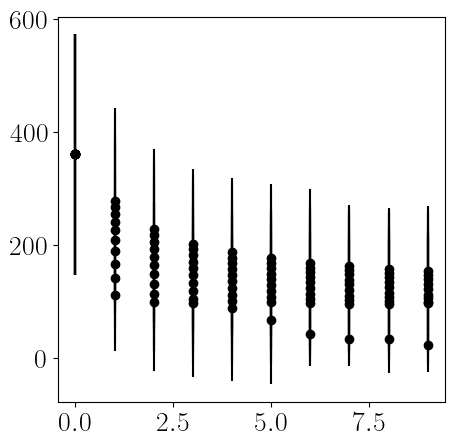

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(df['number'], df['distance_initial_mean'], yerr=df['distance_initial_sigma_1'], fmt='o', color='black', label='Primary')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_80241/3124136825.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


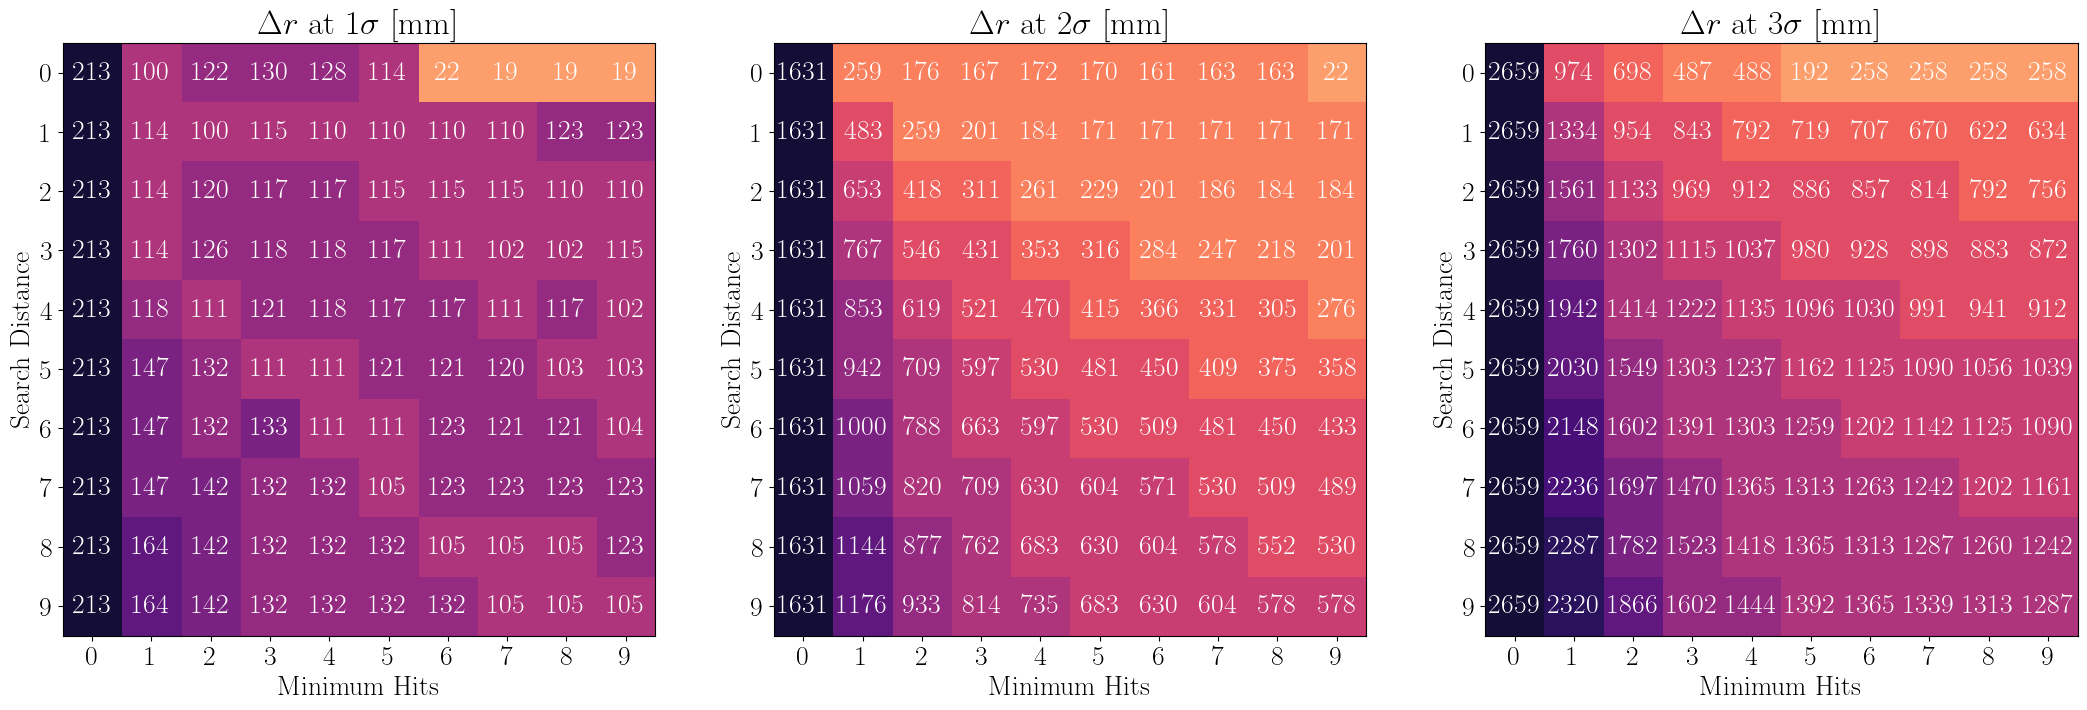

In [5]:
# fig, axes = plt.subplots(1, 3, figsize=(26, 6))
fig, axes = plt.subplots(1, 3, figsize=(26, 8))
size = 20
colors = cm.magma_r
colors = ListedColormap(colors(np.linspace(0.2, 0.9, 12)))
textcolor = 'w'

# Plot for 1-sigma
df_values = np.array(df['distance_initial_sigma_1']).reshape(10, 10)
im = axes[0].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[0].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[0].set_xlabel('Minimum Hits')
axes[0].set_ylabel('Search Distance')
axes[0].set_title(r'$\Delta r$ at $1\sigma$ [mm]')
axes[0].set_aspect('equal')
axes[0].set_xticks(np.arange(df_values.shape[1]))
axes[0].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[0], label=r'$\Delta r$ at $1\sigma$ [mm]')

# Plot for 2-sigma
df_values = np.array(df['distance_initial_sigma_2']).reshape(10, 10)
im = axes[1].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[1].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[1].set_xlabel('Minimum Hits')
axes[1].set_ylabel('Search Distance')
axes[1].set_title(r'$\Delta r$ at $2\sigma$ [mm]')
axes[1].set_aspect('equal')
axes[1].set_xticks(np.arange(df_values.shape[1]))
axes[1].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[1], label=r'$\Delta r$ at $2\sigma$ [mm]')

# Plot for 3-sigma
df_values = np.array(df['distance_initial_sigma_3']).reshape(10, 10)
im = axes[2].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[2].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[2].set_xlabel('Minimum Hits')
axes[2].set_ylabel('Search Distance')
axes[2].set_title(r'$\Delta r$ at $3\sigma$ [mm]')
axes[2].set_aspect('equal')
axes[2].set_xticks(np.arange(df_values.shape[1]))
axes[2].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[2], label=r'$\Delta r$ at $3\sigma$ [mm]')

fig.savefig('../figures/proximityAnalysis_sigmas.pdf', bbox_inches='tight')
fig.show()


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_80241/746112229.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


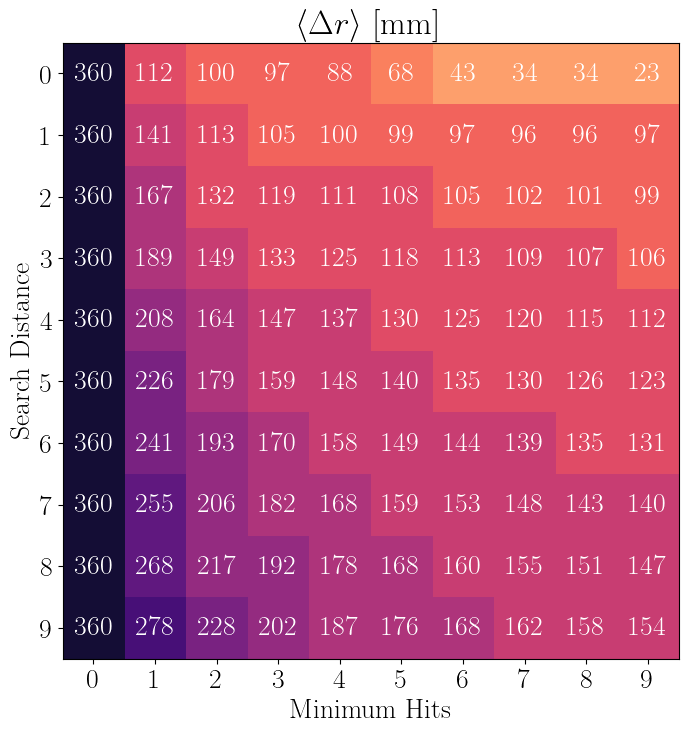

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
df_values = np.array(df['distance_initial_mean']).reshape(10, 10)
im = ax.imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = ax.text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
ax.set_xlabel('Minimum Hits')
ax.set_ylabel('Search Distance')
ax.set_title(r'$\langle \Delta r \rangle$ [mm]')
ax.set_aspect('equal')
ax.set_xticks(np.arange(df_values.shape[1]))
ax.set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=ax, label=r'$\langle \Delta r \rangle$ [mm]')

fig.savefig('../figures/proximityAnalysis_mean.pdf', bbox_inches='tight')
fig.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_80241/1973662040.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


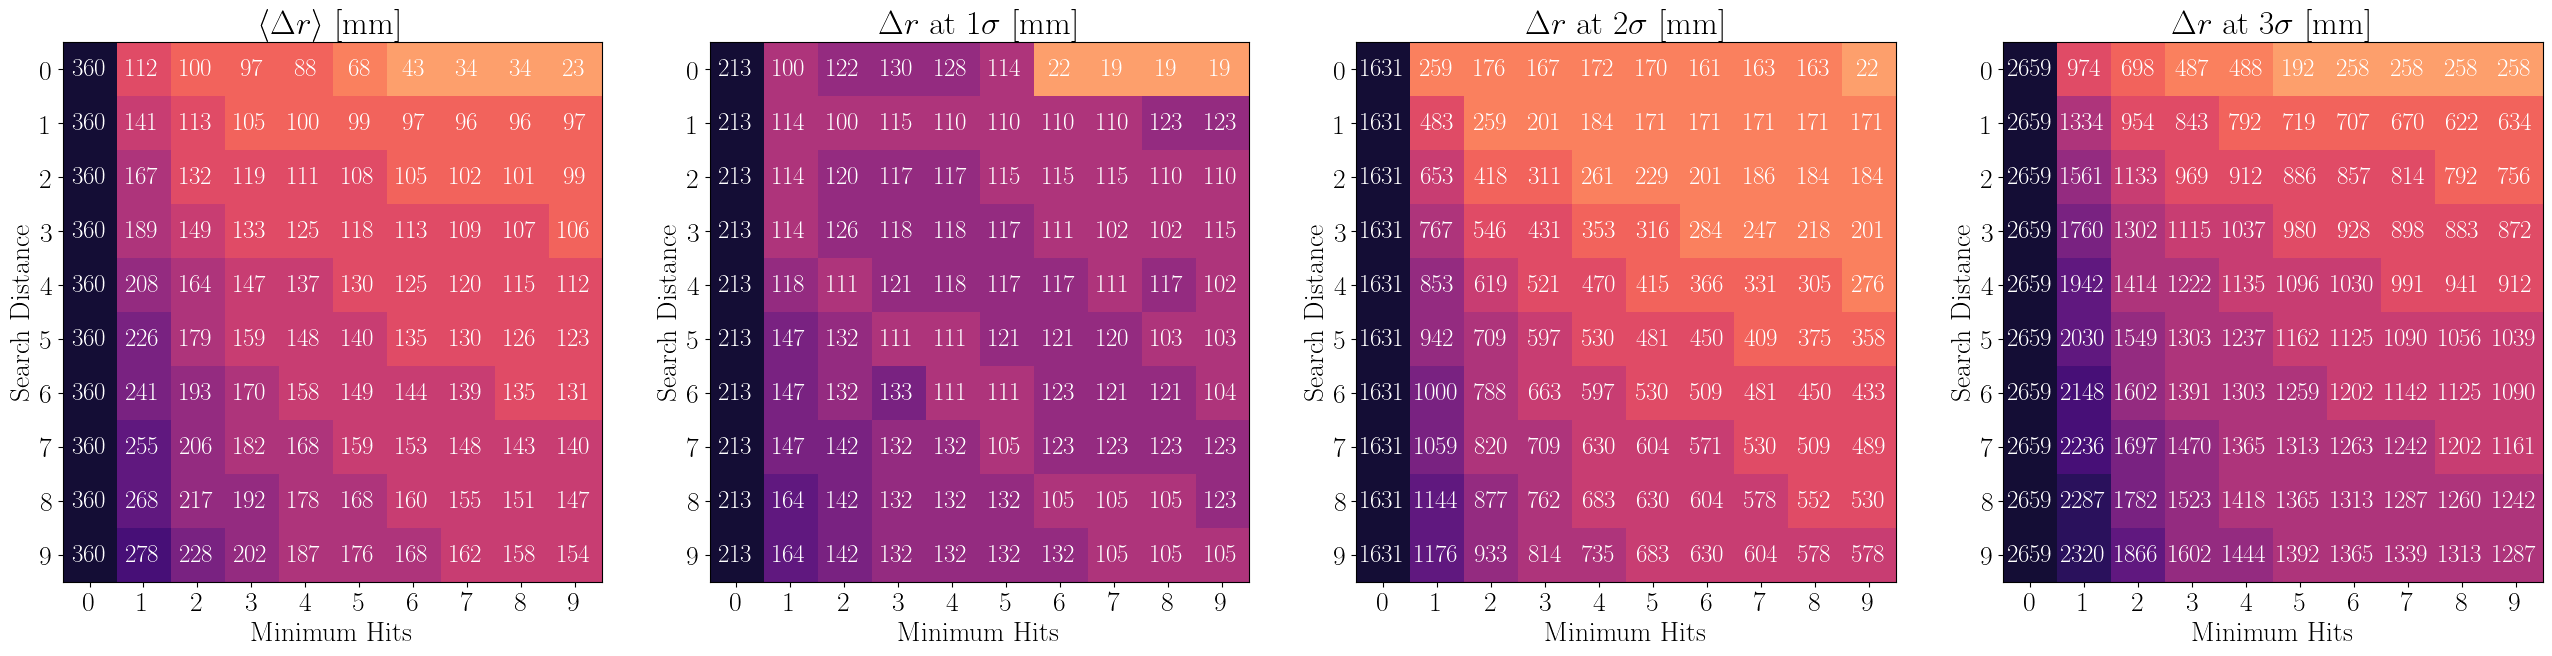

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(32, 8))
size = 18

index = [1, 2, 3, 0]

# Plot for 1-sigma
df_values = np.array(df['distance_initial_sigma_1']).reshape(10, 10)
im = axes[index[0]].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[index[0]].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[index[0]].set_xlabel('Minimum Hits')
axes[index[0]].set_ylabel('Search Distance')
axes[index[0]].set_title(r'$\Delta r$ at $1\sigma$ [mm]')
axes[index[0]].set_aspect('equal')
axes[index[0]].set_xticks(np.arange(df_values.shape[1]))
axes[index[0]].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[0], label=r'$\Delta r$ at $1\sigma$ [mm]')

# Plot for 2-sigma
df_values = np.array(df['distance_initial_sigma_2']).reshape(10, 10)
im = axes[index[1]].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[index[1]].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[index[1]].set_xlabel('Minimum Hits')
axes[index[1]].set_ylabel('Search Distance')
axes[index[1]].set_title(r'$\Delta r$ at $2\sigma$ [mm]')
axes[index[1]].set_aspect('equal')
axes[index[1]].set_xticks(np.arange(df_values.shape[1]))
axes[index[1]].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[1], label=r'$\Delta r$ at $2\sigma$ [mm]')

# Plot for 3-sigma
df_values = np.array(df['distance_initial_sigma_3']).reshape(10, 10)
im = axes[index[2]].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[index[2]].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[index[2]].set_xlabel('Minimum Hits')
axes[index[2]].set_ylabel('Search Distance')
axes[index[2]].set_title(r'$\Delta r$ at $3\sigma$ [mm]')
axes[index[2]].set_aspect('equal')
axes[index[2]].set_xticks(np.arange(df_values.shape[1]))
axes[index[2]].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[2], label=r'$\Delta r$ at $3\sigma$ [mm]')

# Plot for mean
df_values = np.array(df['distance_initial_mean']).reshape(10, 10)
im = axes[index[3]].imshow(df_values, cmap=colors, aspect='auto')
for i in range(df_values.shape[0]):
    for j in range(df_values.shape[1]):
        text = axes[index[3]].text(j, i, f'{df_values[i, j]:.0f}', ha='center', va='center', color=textcolor, size=size)
axes[index[3]].set_xlabel('Minimum Hits')
axes[index[3]].set_ylabel('Search Distance')
axes[index[3]].set_title(r'$\langle \Delta r \rangle$ [mm]')
axes[index[3]].set_aspect('equal')
axes[index[3]].set_xticks(np.arange(df_values.shape[1]))
axes[index[3]].set_yticks(np.arange(df_values.shape[0]))
# cbar = fig.colorbar(im, ax=axes[3], label=r'$\langle \Delta r \rangle$ [mm]')

fig.savefig('../figures/proximityAnalysis_meanAndSigmas.pdf', bbox_inches='tight')
fig.show()
